In [9]:
import pandas as pd
import glob
import os
import nltk

### Import Data

In [10]:
#import csv files and concatenate into one df

path = ''                   
all_files = glob.glob(os.path.join(path, "*.csv")) 

df_from_each_file = (pd.read_csv(f) for f in all_files)
songs = pd.concat(df_from_each_file, ignore_index=True)

In [11]:
songs

,album_name,track_title,track_n,lyric,line
0,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1
1,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2
2,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3
3,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4
4,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5
...,...,...,...,...,...
8353,evermore (deluxe version),​it’s time to go,17,"You know, you know, you know, you know",50
8354,evermore (deluxe version),​it’s time to go,17,When it's time to go,51
8355,evermore (deluxe version),​it’s time to go,17,So then you go,52
8356,evermore (deluxe version),​it’s time to go,17,Then you go,53


## Data Cleaning

In [12]:
# Grouping all lines of a song together
songs1 = songs.groupby(['album_name','track_title'], as_index=False).agg({'track_title' : 'first', 'lyric' : ' '.join})
songs1

,album_name,track_title,lyric
0,1989 (Deluxe),All You Had to Do Was Stay,"(Hey, hey, hey) (Hey, hey, hey) (Hey, hey, hey..."
1,1989 (Deluxe),Bad Blood,"'Cause baby, now we've got bad blood You know ..."
2,1989 (Deluxe),Blank Space,"Nice to meet you, where you been? I could show..."
3,1989 (Deluxe),Clean,"The drought was the very worst (Oh-oh, oh-oh) ..."
4,1989 (Deluxe),How You Get the Girl,"Oh, oh, oh Oh, oh, oh Oh-oh, oh-oh Stand there..."
...,...,...,...
158,reputation,King of My Heart,"I'm perfectly fine, I live on my own I made up..."
159,reputation,Look What You Made Me Do,I don't like your little games Don't like your...
160,reputation,New Year’s Day,There's glitter on the floor after the party G...
161,reputation,So It Goes...,"See you in the dark All eyes on you, my magici..."


#### Noise Removal and Text Normalization

In [13]:
#lowercasing
songs1['lyric'] = songs1['lyric'].str.lower()

In [14]:
# removing punctuation
songs1['lyric'] = songs1['lyric'].str.replace(r'[^\w\s]+', '', regex=True)

In [15]:
# removing stopwords
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
tstop_words = ['oh', 'ah', 'ohoh', 'eh', 'yeah', 'i', 'ii','ohohoh', 'shes', 'hes', 'ill', 'youre', 'youd', 'hey', 'id', 'im', 'like', 'whoa', 'ooh', 'youll', 'said', 'say', 'know', 'knew']
songs1['lyric'] = songs1['lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
songs1['lyric'] = songs1['lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (tstop_words)]))

In [16]:
songs1['lyric'][0]

'people always want back love gave away people wanna believe youve changed think less drove us road stay stay palm hand whyd go lock let stay want back late well couldve easy stay stay stay stay stay calling dont ive picking pieces mess made people always want back love pushed aside people gone forever goodbye stay stay palm hand whyd go lock let stay want back late well couldve easy stay stay stay stay stay stay stay stay let remind wanted ended wanted stay stay palm hand whyd want go lock let stay want back late well couldve easy stay stay palm hand whyd go lock let stay want back late well couldve easy stay stay stay stay stay stay'

In [17]:
# Tokenization
from nltk.tokenize import word_tokenize
songs2 = songs1.copy()
#songs2['lyric'] = songs2.apply(lambda row: nltk.word_tokenize(row['lyric']), axis=1)

## tf-idf Model

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( 
                                lowercase=True,
                                max_df=0.75,
                                min_df=10,
                                stop_words= 'english'
                            )
vectors = vectorizer.fit_transform(songs2['lyric'])
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for lyrics in denselist:
    x = 0
    keywords = []
    for word in lyrics:
        if word > 0:
            keywords.append(feature_names[x])
        x = x+1
    all_keywords.append(keywords)

print(all_keywords[0])


['away', 'believe', 'dont', 'forever', 'gave', 'gone', 'goodbye', 'hand', 'ive', 'late', 'let', 'love', 'people', 'road', 'stay', 'think', 'wanna', 'want', 'wanted', 'youve']


## Non-Negative Matrix Factorization (Topic Modeling)

In [19]:
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=6)
nmf_model.fit(vectors)

c:\Users\jcr\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=6)

In [20]:
# generating topics
for index,topic in enumerate(nmf_model.components_):
    print(f'Topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

Topic #0
['gave', 'bad', 'remember', 'better', 'wishing', 'ive', 'goes', 'look', 'cause', 'right', 'thing', 'long', 'tell', 'got', 'time']


Topic #1
['meet', 'darling', 'night', 'let', 'wish', 'best', 'run', 'beautiful', 'look', 'dress', 'dancing', 'need', 'want', 'wanna', 'dont']


Topic #2
['play', 'things', 'touch', 'ive', 'eyes', 'lights', 'feel', 'baby', 'coming', 'beautiful', 'gonna', 'way', 'saw', 'good', 'love']


Topic #3
['little', 'kiss', 'way', 'feeling', 'friend', 'feel', 'new', 'got', 'rain', 'cause', 'gone', 'people', 'baby', 'thought', 'come']


Topic #4
['hand', 'hate', 'trying', 'forever', 'rain', 'bad', 'cause', 'waiting', 'fun', 'gonna', 'man', 'girl', 'want', 'baby', 'thats']


Topic #5
['drive', 'things', 'known', 'gone', 'night', 'shine', 'away', 'better', 'mind', 'forever', 'didnt', 'hope', 'stay', 'home', 'think']




In [21]:
# Creating topic column
topic_results = nmf_model.transform(vectors)
songs2['topic'] = topic_results.argmax(axis=1)

In [22]:
topic_array = pd.DataFrame(topic_results)
topic_array

,0,1,2,3,4,5
0,0.000000,0.025545,0.000000,0.000000,0.011568,0.283404
1,0.156632,0.024237,0.083202,0.038309,0.104275,0.072290
2,0.166969,0.043687,0.237297,0.083198,0.076911,0.000000
3,0.000000,0.009926,0.000000,0.026755,0.189390,0.272520
4,0.000000,0.000000,0.000000,0.000000,0.545587,0.000000
...,...,...,...,...,...,...
158,0.011129,0.028693,0.064836,0.023326,0.101868,0.000000
159,0.123685,0.121870,0.000000,0.000000,0.000000,0.000000
160,0.037817,0.116767,0.000000,0.000000,0.028109,0.046818
161,0.113213,0.000000,0.018440,0.111304,0.111497,0.000000


In [23]:
track = songs2['track_title']
topics_tracks = pd.concat([topic_array, track], axis=1)
topics_tracks.set_index('track_title')

,0,1,2,3,4,5
track_title,,,,,,
All You Had to Do Was Stay,0.000000,0.025545,0.000000,0.000000,0.011568,0.283404
Bad Blood,0.156632,0.024237,0.083202,0.038309,0.104275,0.072290
Blank Space,0.166969,0.043687,0.237297,0.083198,0.076911,0.000000
Clean,0.000000,0.009926,0.000000,0.026755,0.189390,0.272520
How You Get the Girl,0.000000,0.000000,0.000000,0.000000,0.545587,0.000000
...,...,...,...,...,...,...
King of My Heart,0.011129,0.028693,0.064836,0.023326,0.101868,0.000000
Look What You Made Me Do,0.123685,0.121870,0.000000,0.000000,0.000000,0.000000
New Year’s Day,0.037817,0.116767,0.000000,0.000000,0.028109,0.046818


In [24]:
# creating topic labels
topic_dict = {0: 'Threatening/Powerful', 1: 'Dancing', 2: 'Love/Beauty', 3: 'Romantic', 4: 'Desire', 5: 'Loss/Vulnerability'}
songs2['topic label'] = songs2['topic'].map(topic_dict)

In [25]:
songs2

,album_name,track_title,lyric,topic,topic label
0,1989 (Deluxe),All You Had to Do Was Stay,people always want back love gave away people ...,5,Loss/Vulnerability
1,1989 (Deluxe),Bad Blood,cause baby weve got bad blood used mad love ta...,0,Threatening/Powerful
2,1989 (Deluxe),Blank Space,nice meet could show incredible things magic m...,2,Love/Beauty
3,1989 (Deluxe),Clean,drought worst flowers wed grown together died ...,5,Loss/Vulnerability
4,1989 (Deluxe),How You Get the Girl,stand ghost shaking rain rain shell open door ...,4,Desire
...,...,...,...,...,...
158,reputation,King of My Heart,perfectly fine live made mind better bein alon...,4,Desire
159,reputation,Look What You Made Me Do,dont little games dont tilted stage role made ...,0,Threatening/Powerful
160,reputation,New Year’s Day,theres glitter floor party girls carrying shoe...,1,Dancing
161,reputation,So It Goes...,see dark eyes magician eyes us make everyone d...,0,Threatening/Powerful


In [37]:
album_years = pd.DataFrame([
    ["Taylor Swift", 2006],
    ["Fearless (Taylor’s Version)", 2008],
    ["Speak Now (Deluxe)", 2010],
    ["Red (Deluxe Edition)", 2012],
    ["1989 (Deluxe)", 2014],
    ["reputation", 2017],
    ["Lover", 2019],
    ["folklore (deluxe version)", 2020],
    ["evermore (deluxe version)", 2020],
    ["Midnights", 2022],
], columns=["album_name", "year"])

p_df = (
songs2
    .merge(album_years, on="album_name", how="left")
    .groupby(["year", "topic label"])
    .agg(n_songs = ("track_title", "count"))
    )

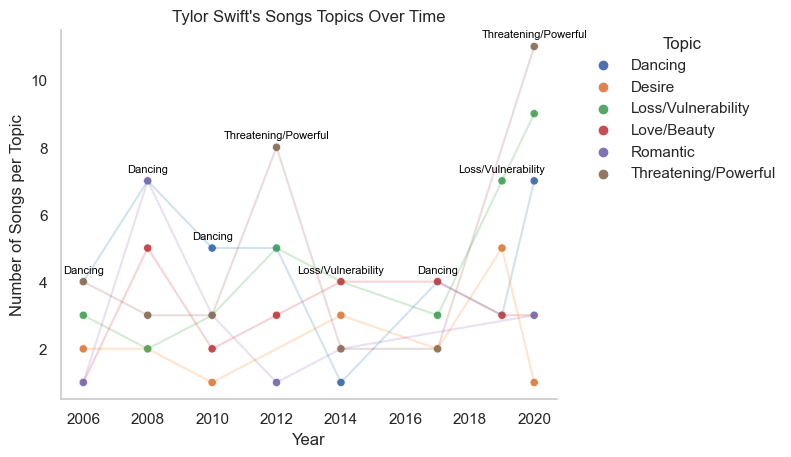

In [85]:
# create a line plot with seaborn
import seaborn as sns
import matplotlib.pyplot as plt


sns.lineplot(data=p_df, x="year", y="n_songs", hue="topic label", 
            alpha=0.2, palette="tab10", legend=False)
sns.scatterplot(data=p_df, x="year", y="n_songs", hue="topic label", alpha=1)

# remove the legend from the scatter plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Topic", frameon=False)

# add a label for the most popular topic for each year
for year in p_df.index.get_level_values("year").unique():
    top_topic = p_df.loc[year].sort_values("n_songs", ascending=False).index[0]
    top_n = p_df.loc[year].sort_values("n_songs", ascending=False).iloc[0, 0]
    plt.text(
        year, top_n + .2, top_topic,
        horizontalalignment='center',
        verticalalignment="bottom",
        color="black",
        fontsize=8,
        )

# tile songs topic over time
plt.title("Tylor Swift's Songs Topics Over Time")

# xlabel title
plt.xlabel("Year")

# ylabel title
plt.ylabel("Number of Songs per Topic")
# remove grid lines
plt.grid(False)
sns.despine()

plt.show()


In [103]:
# plot = songs2.groupby('album_name')['topic label'].value_counts().to_frame()
# plot

## Create a bag of words

c:\Users\jcr\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 163 samples in 0.001s...
[t-SNE] Computed neighbors for 163 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 163 / 163
[t-SNE] Mean sigma: 6.817547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.141533
[t-SNE] KL divergence after 1000 iterations: 0.845427


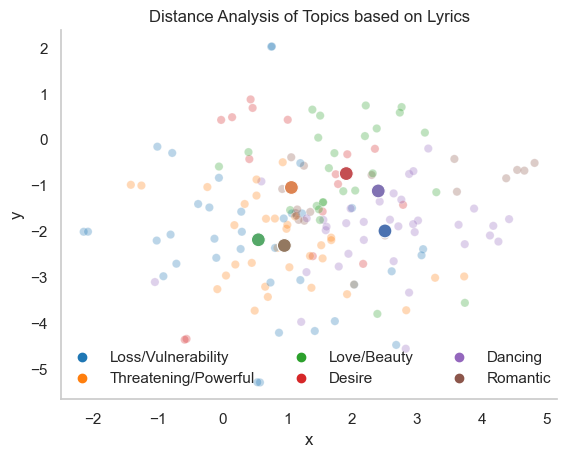

In [161]:
# create a bag of words
from matplotlib.ft2font import BOLD
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.85, stop_words='english')
word_count_vector = cv.fit_transform(songs2['lyric'],)

# plot a t-sne model
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
tsne_lda = tsne_model.fit_transform(word_count_vector)

# create a dataframe
tsne_lda_df = pd.DataFrame(tsne_lda, columns=['x', 'y'])
tsne_lda_df['topic'] = songs2['topic label']

# plot the t-sne model
sns.scatterplot(x='x', y='y', hue="topic", data=tsne_lda_df, palette="tab10", alpha=0.3)

# get topic centers from the nmf model
topics_centers = (
tsne_lda_df
    .groupby("topic")
    .agg(x = ("x", "mean"), y = ("y", "mean"))
    .reset_index()
)
# add topics centers to the plot
sns.scatterplot(
    x='x', y='y', 
    hue="topic", 
    data=topics_centers, 
    s=100, legend=False)

# title distance analysis of topics in relation to lyrics
plt.title("Distance Analysis of Topics based on Lyrics")

# remove grid
plt.grid(False)
sns.despine()

# move legend to the right
plt.legend(frameon=False,
            # position the legend on the bottom as row
            loc='lower center',
            # number of columns
            ncol=3,
)
plt.show()



,x,y
topic,,
Dancing,2.506242,-1.998657
Desire,1.063119,-1.051847
Loss/Vulnerability,0.553430,-2.191138
Love/Beauty,1.909482,-0.748469
Romantic,2.402627,-1.126973
Threatening/Powerful,0.954359,-2.315983


### Scattertext Plot

Visualizes linguistic variation between albums. Each axis corresponds to the rank-frequency a term occurs in a category of documents.

In [88]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import scattertext as st
nlp = spacy.load("en_core_web_sm", disable=["lemmatizer", 'tagger', 'ner'])
songs2['parsed'] = songs2['lyric'].apply(nlp)

In [ ]:
corpus = st.CorpusFromParsedDocuments(songs2,
                             category_col='album_name',
                             parsed_col='parsed').build()

In [ ]:
html = st.produce_scattertext_explorer(corpus,
          category='evermore (deluxe version)',
          category_name='evermore (deluxe version)',
          not_category_name='folklore (deluxe version)',
          width_in_pixels=1000,
          minimum_term_frequency=5,
          transform=st.Scalers.dense_rank
          )

In [ ]:
file_name = 'ts.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1000, height=1000)

## Word2Vec (word embedding)

Word2vec is a technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. 

In [82]:
# open source python library for NLP
import gensim

In [83]:
# tokenize text 
songs2['lyric'] = songs2.apply(lambda row: nltk.word_tokenize(row['lyric']), axis=1)

In [84]:
lyrics = songs2['lyric']

#### Initialize the model

In [85]:
model = gensim.models.Word2Vec(
        window=10,
        min_count=2,
)

#### Build Vocabulary

In [86]:
model.build_vocab(lyrics)

#### Train the Model

In [87]:
model.train(lyrics, total_examples=model.corpus_count, epochs=model.epochs)

(109547, 132975)

In [88]:
model.wv.most_similar("bad")

[('cause', 0.9997600317001343),
 ('eyes', 0.999732255935669),
 ('whole', 0.999727189540863),
 ('got', 0.9997147917747498),
 ('best', 0.9997144937515259),
 ('well', 0.9997109174728394),
 ('lost', 0.9997066259384155),
 ('around', 0.9997054934501648),
 ('nothing', 0.999704897403717),
 ('one', 0.9996944665908813)]

In [89]:
model.wv

## t-sne Model

a dimensionality reduction technique used to represent high-dimensional dataset in a low-dimensional space of two or three dimensions

In [90]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [91]:
labels = [i for i in model.wv.key_to_index.keys()]
tokens = model[labels]

tsne_model = TSNE(init='pca',learning_rate='auto')
new_values = tsne_model.fit_transform(tokens)

TypeError: 'Word2Vec' object is not subscriptable

In [ ]:
plt.figure(figsize=(7, 5)) 
for i in range(new_values.shape[0]):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

In [94]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

   
    for word in model.vocab:
        tokens.append(word)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca',)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [95]:
tsne_plot(model)

AttributeError: 'Word2Vec' object has no attribute 'vocab'

## Text Generator

In [ ]:
import sys 
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [ ]:
songs = songs.to_csv('songs.csv')

In [ ]:
ts = pd.read_csv('songs.csv')
ts

Concatenate the lines of each song to get each song by its own in one string

In [ ]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName
# define empty lists for the lyrics , songID , songName 
lyrics = []
songID = []
songName = []
# songNumber indicates the song number in the dataset
songNumber = 1
# i indicates the song number
i = 0
isFirstLine = True
# Iterate through every lyrics line and join them together for each song independently 
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we still in the same song , keep joining the lyrics lines    
            lyrics[i] +=  row['lyric'] + '\n'
    #When it's done joining a song's lyrics lines , go to the next song :    
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1